# Workflows and Agents

Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents. 

It highlights both "agents" and "workflows":

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined "workflows". At Anthropic, we categorize all these variations as agentic systems.

It explains the primary difference between agents and workflows: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

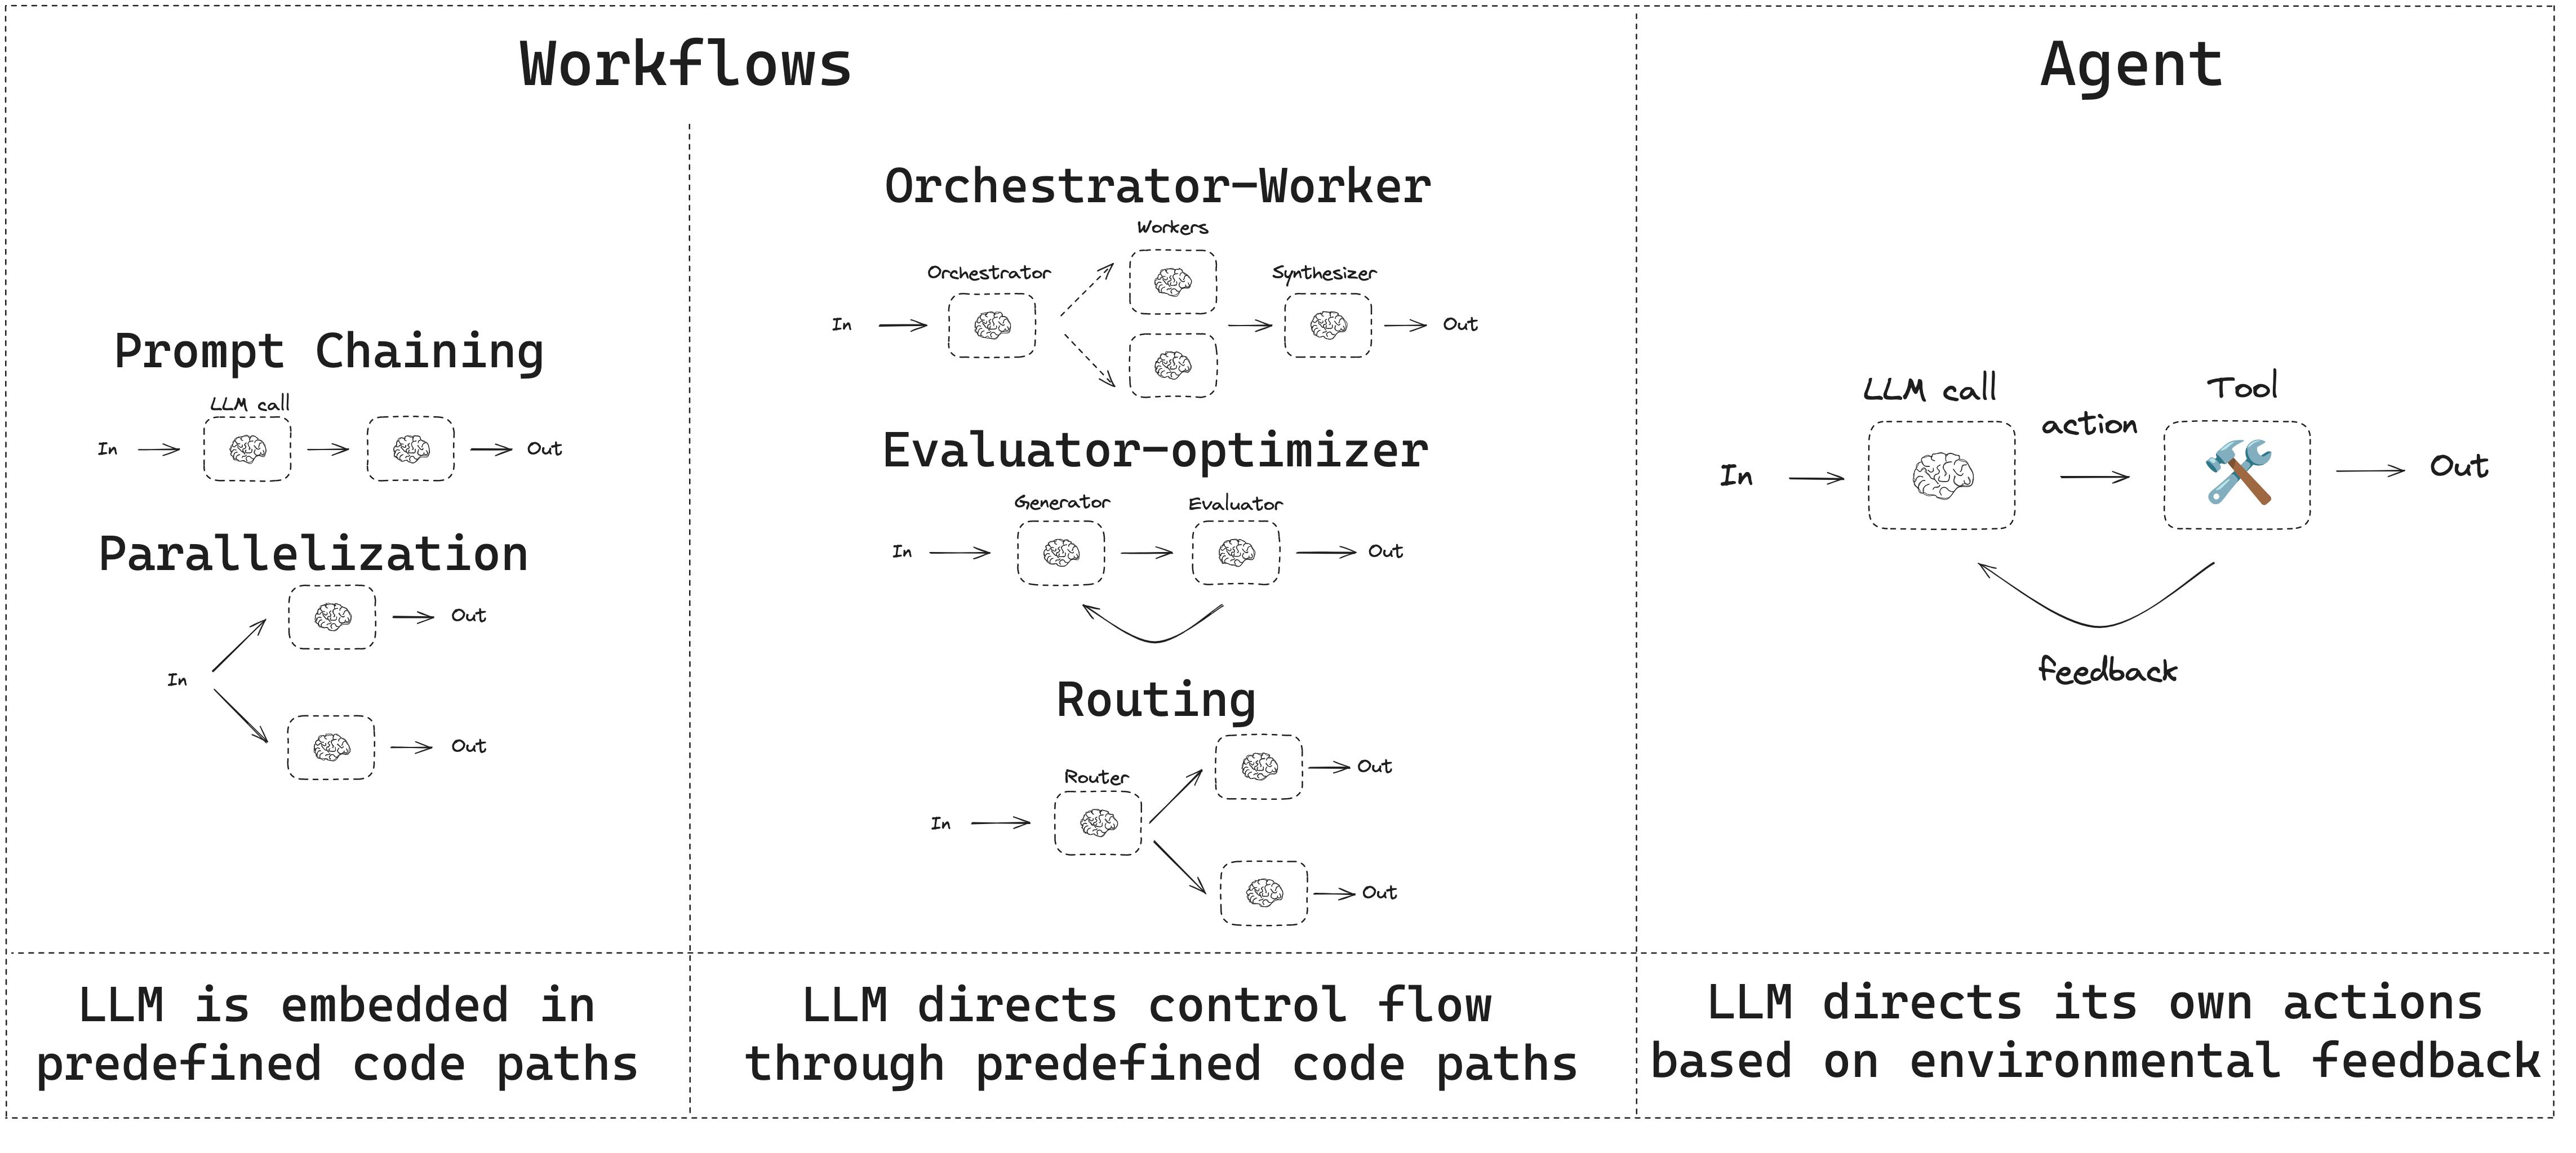

## Why use a framework like LangGraph?

With agents and workflows defined, the blog discusses whether to use agent frameworks.

For any framework, it is important to understand the costs (or overhead) of using it versus the benefits.

The blog points out that frameworks *can* add abstraction, often to promote speed or ease of use. 

But, this can come with costs, such as difficulty debugging or incorrect assumptions.

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts and responses, making them harder to debug.

LangGraph aims to minimize costs / overhead by providing low-level building blocks for building workflows / agents.

These building blocks can be flexibly used to build any workflow / agent architecture.

A central building block in LangGraph is the [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), which sits below any workflow or agent you implement.

This persistence layer enables several features are generally important for agents and workflows:

* Short-term and long-term [memory](https://langchain-ai.github.io/langgraph/concepts/memory/)
* [Interruption and resuming](https://langchain-ai.github.io/langgraph/concepts/breakpoints/) of workflows or agents
* [Human-in-the-loop](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) (e.g., to approve an agent's actions)
  
The blog makes an interesting point related to the importance of persistence:
 
> Agents can then *pause for human feedback at checkpoints* or when encountering blockers.

Beyond persistence, LangGraph provides a number of other benefits for building effective agents and workflows:

* Flexible streaming of agent or workflow state
* Easy onramp for deployment

We provide more resources on persistence, streaming, and deployment at the end of this document. 

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in the blog:

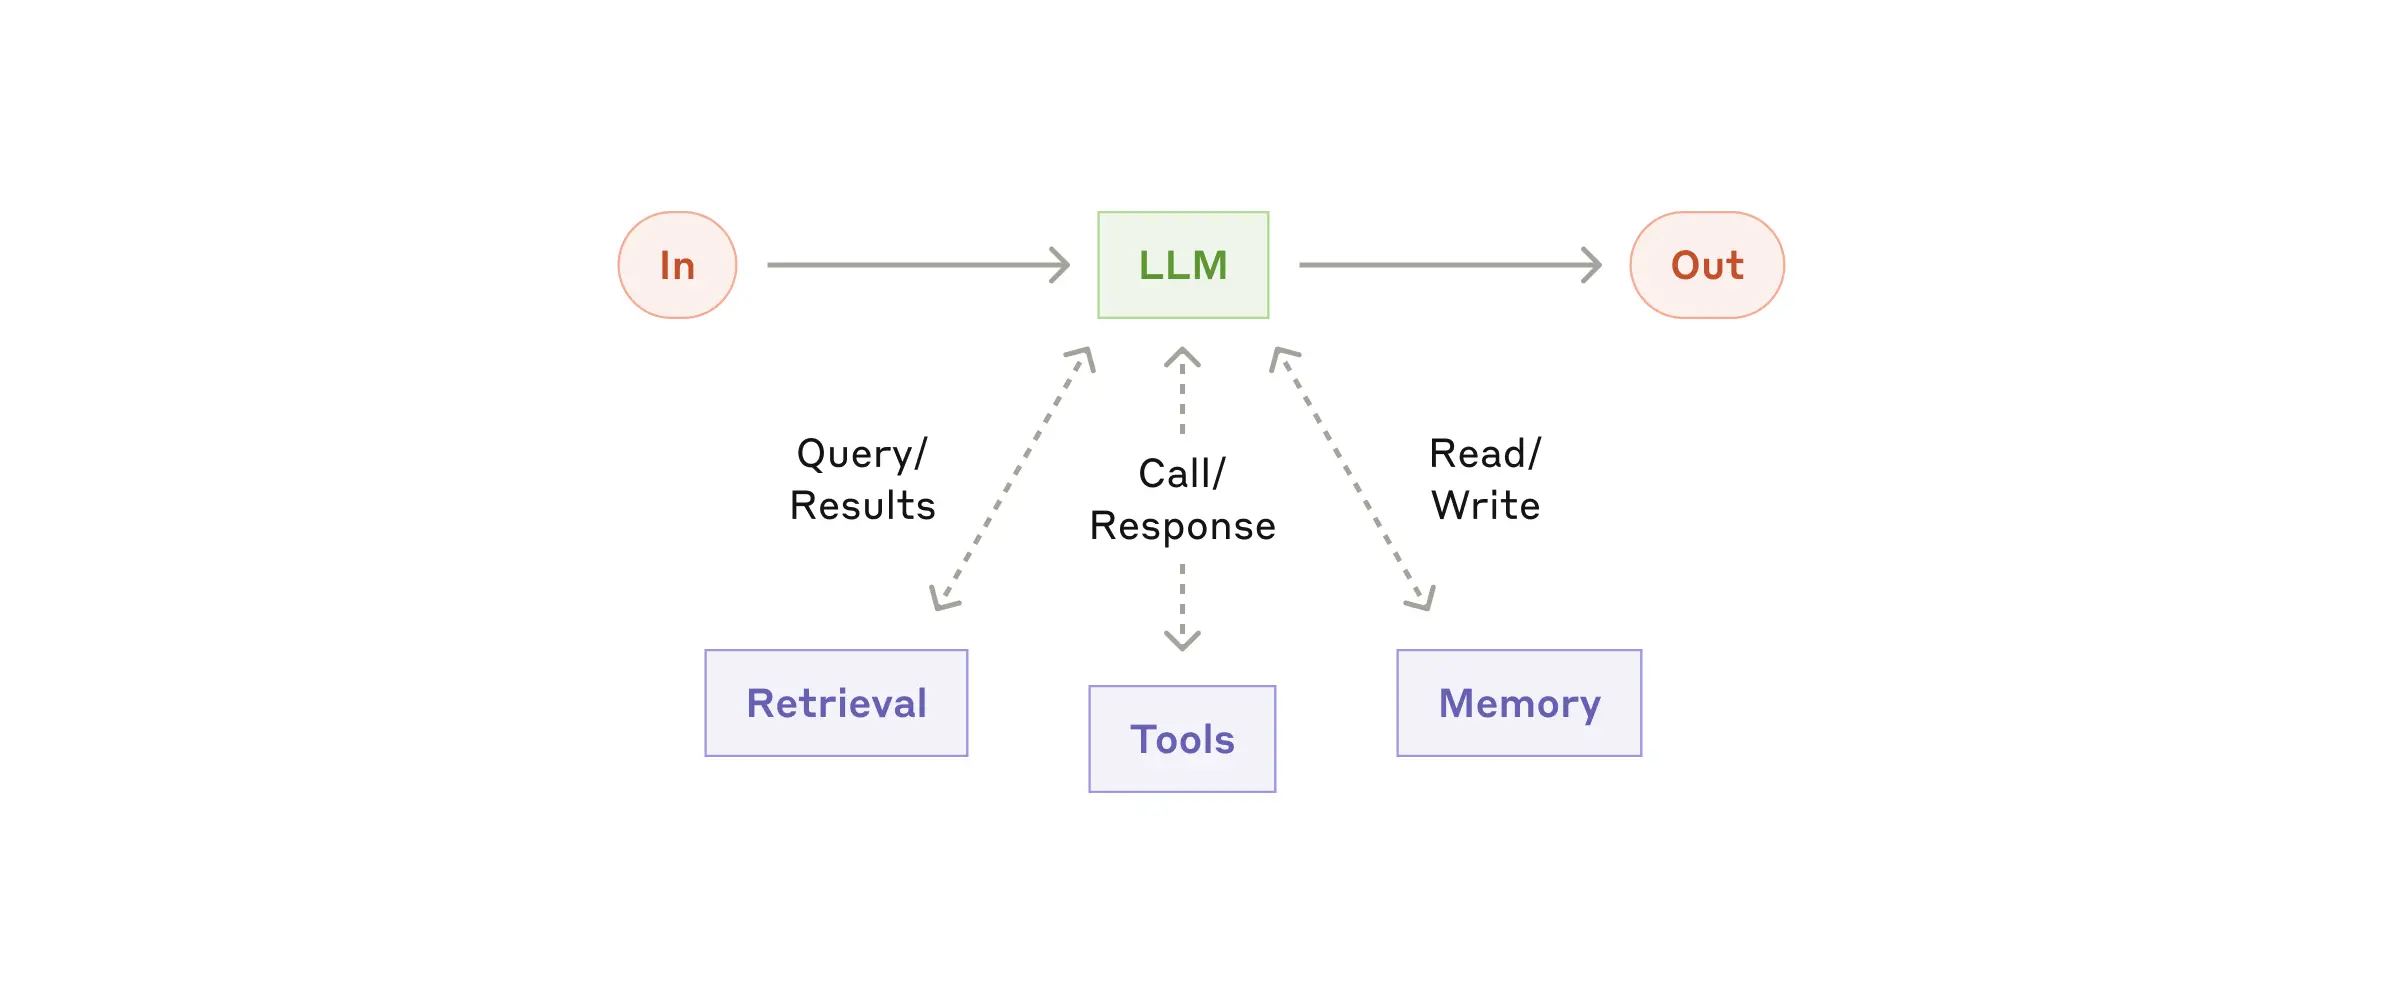

Select [any chat model](https://python.langchain.com/docs/integrations/chat/) that supports structured outputs or tool calling. 

Below, we show how to use LangGraph with OpenAI and Anthropic. 

In [1]:
%pip install langchain_core langchain-openai langchain-anthropic langgraph 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [3]:
_set_env("LANGSMITH_API_KEY")

LANGSMITH_API_KEY:  ········


In [4]:
os.environ["LANGSMITH_TRACING_V2"] = "true"

In [5]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [6]:
from pydantic import BaseModel, Field

# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized web search."
    )
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

Calcium CT score and high cholesterol relation
None


In [7]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_GFi0tkwOB8BU3YMH2kyO2Vsy',
  'type': 'tool_call'}]

## Prompt chaining

In prompt chaining, each LLM call processes the output of the previous one. As noted in the [blog](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

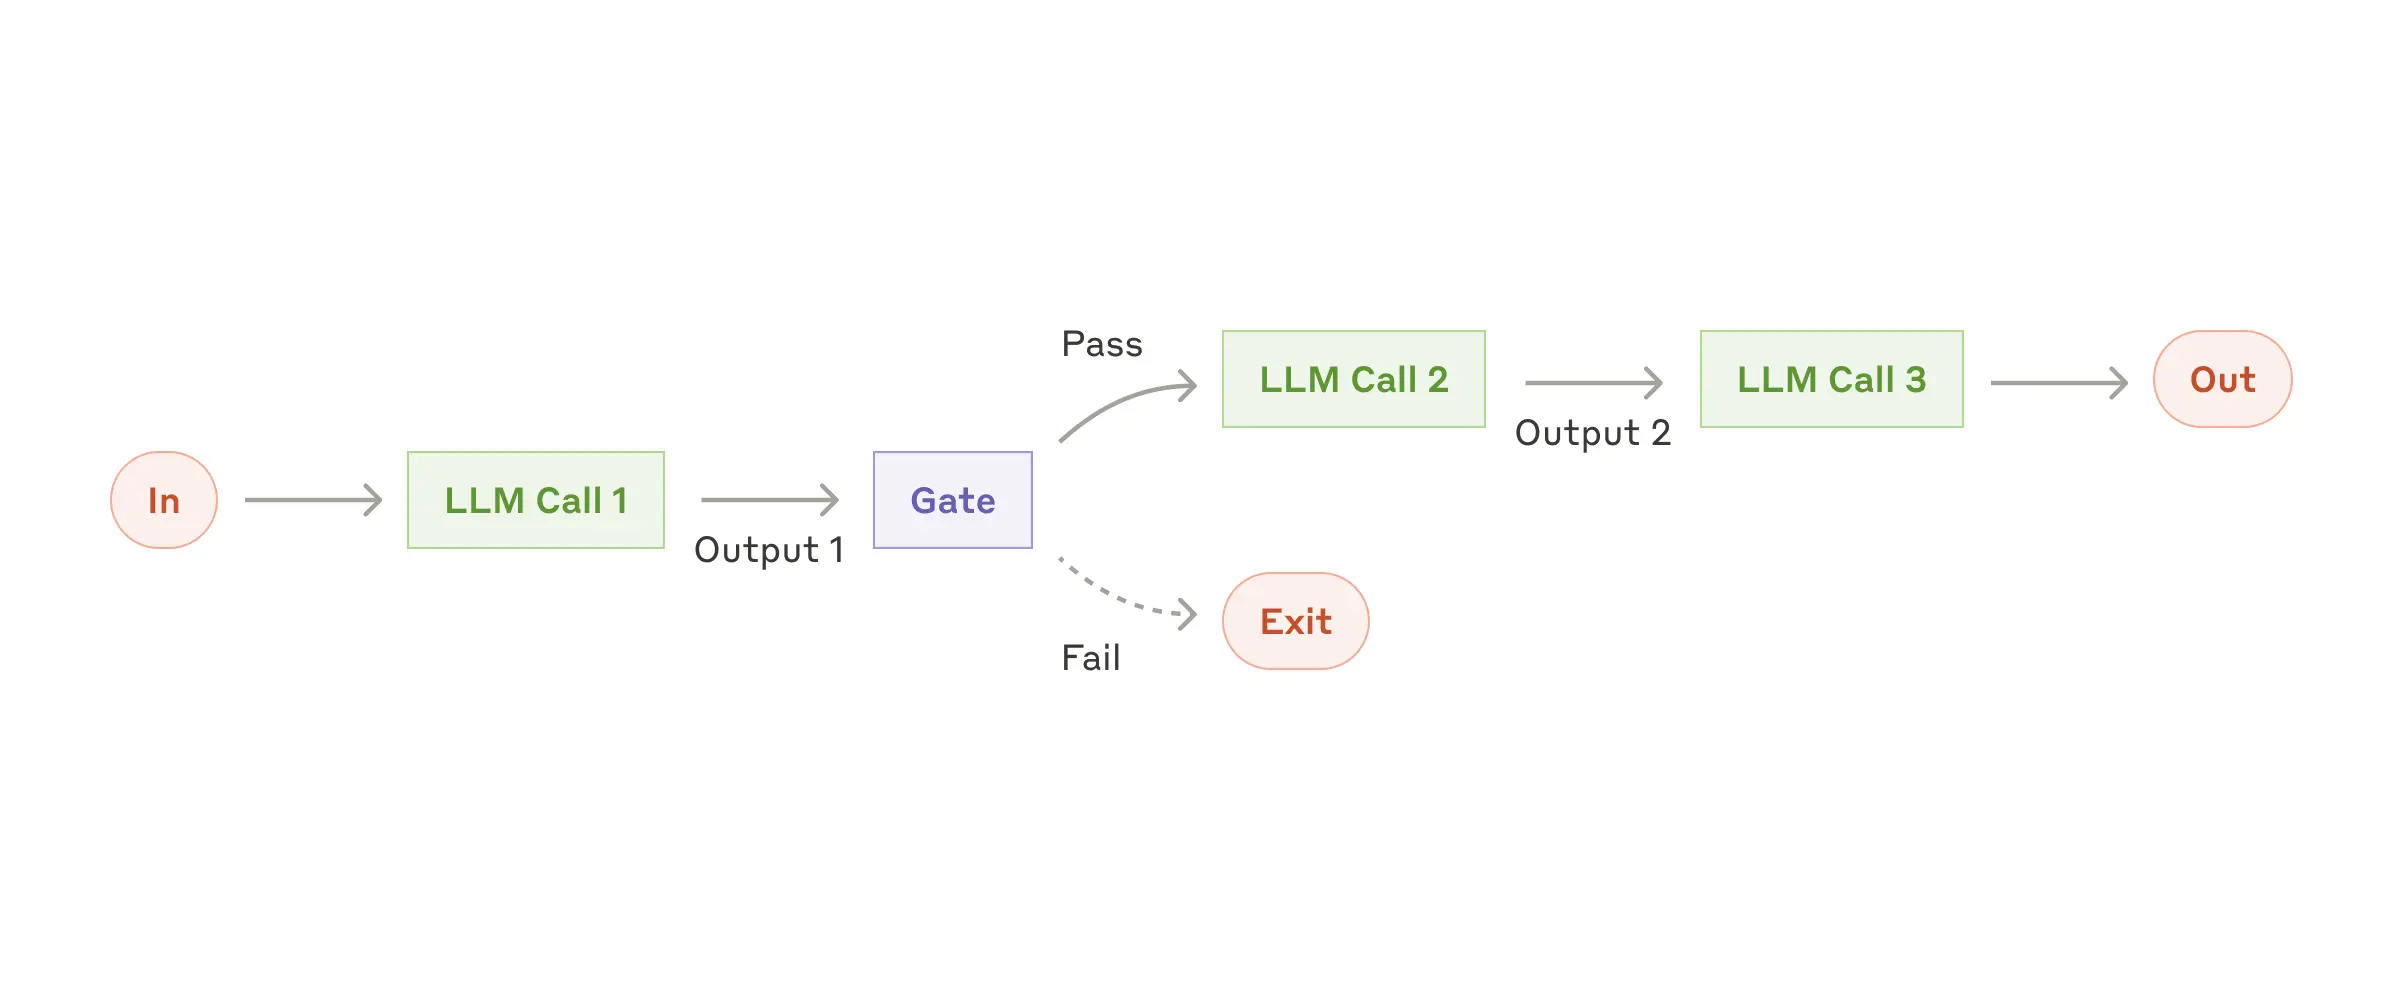

#### Resources

**LangChain Academy**
 
See our lesson on Prompt Chaining here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb

#### Example Implementation


In [8]:
from langgraph.func import entrypoint, task

# Tasks
@task
def generate_joke(topic: str):
    """First LLM call to generate initial joke """
    msg = llm.invoke(f"Write a short joke about {topic}")
    return msg.content

def check_punchline(joke: str):
    """Gate function to check if the joke has a punchline """
    # Simple check - does the joke contain "?" or "!"
    if "?" in joke or "!" in joke:
        return "Fail"

    return "Pass"

@task
def improve_joke(joke: str):
    """Second LLM call to improve the joke """
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {joke}")
    return msg.content

@task
def polish_joke(joke: str):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {joke}")
    return msg.content

@entrypoint()
def workflow(topic: str):
    original_joke = generate_joke(topic).result()
    if check_punchline(original_joke) == "Pass":
        return original_joke

    improved_joke = improve_joke(original_joke).result()
    return polish_joke(improved_joke).result()

In [9]:
for step in workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'generate_joke': 'Why was the cat sitting on the computer?\n\nIt wanted to keep an eye on the mouse!'}


{'improve_joke': 'Why was the cat sitting on the computer? It wanted to keep an eye on the mouse, but it also heard there were some juicy "bytes" to catch!'}


{'polish_joke': 'Why was the cat sitting on the computer? It wanted to keep an eye on the mouse, but it also heard there were some juicy "bytes" to catch! Little did it know, it was actually downloading a program to take over the world, one nap at a time!'}


{'workflow': 'Why was the cat sitting on the computer? It wanted to keep an eye on the mouse, but it also heard there were some juicy "bytes" to catch! Little did it know, it was actually downloading a program to take over the world, one nap at a time!'}




## Parallelization 

With parallelization, LLMs work simultaneously on a task. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

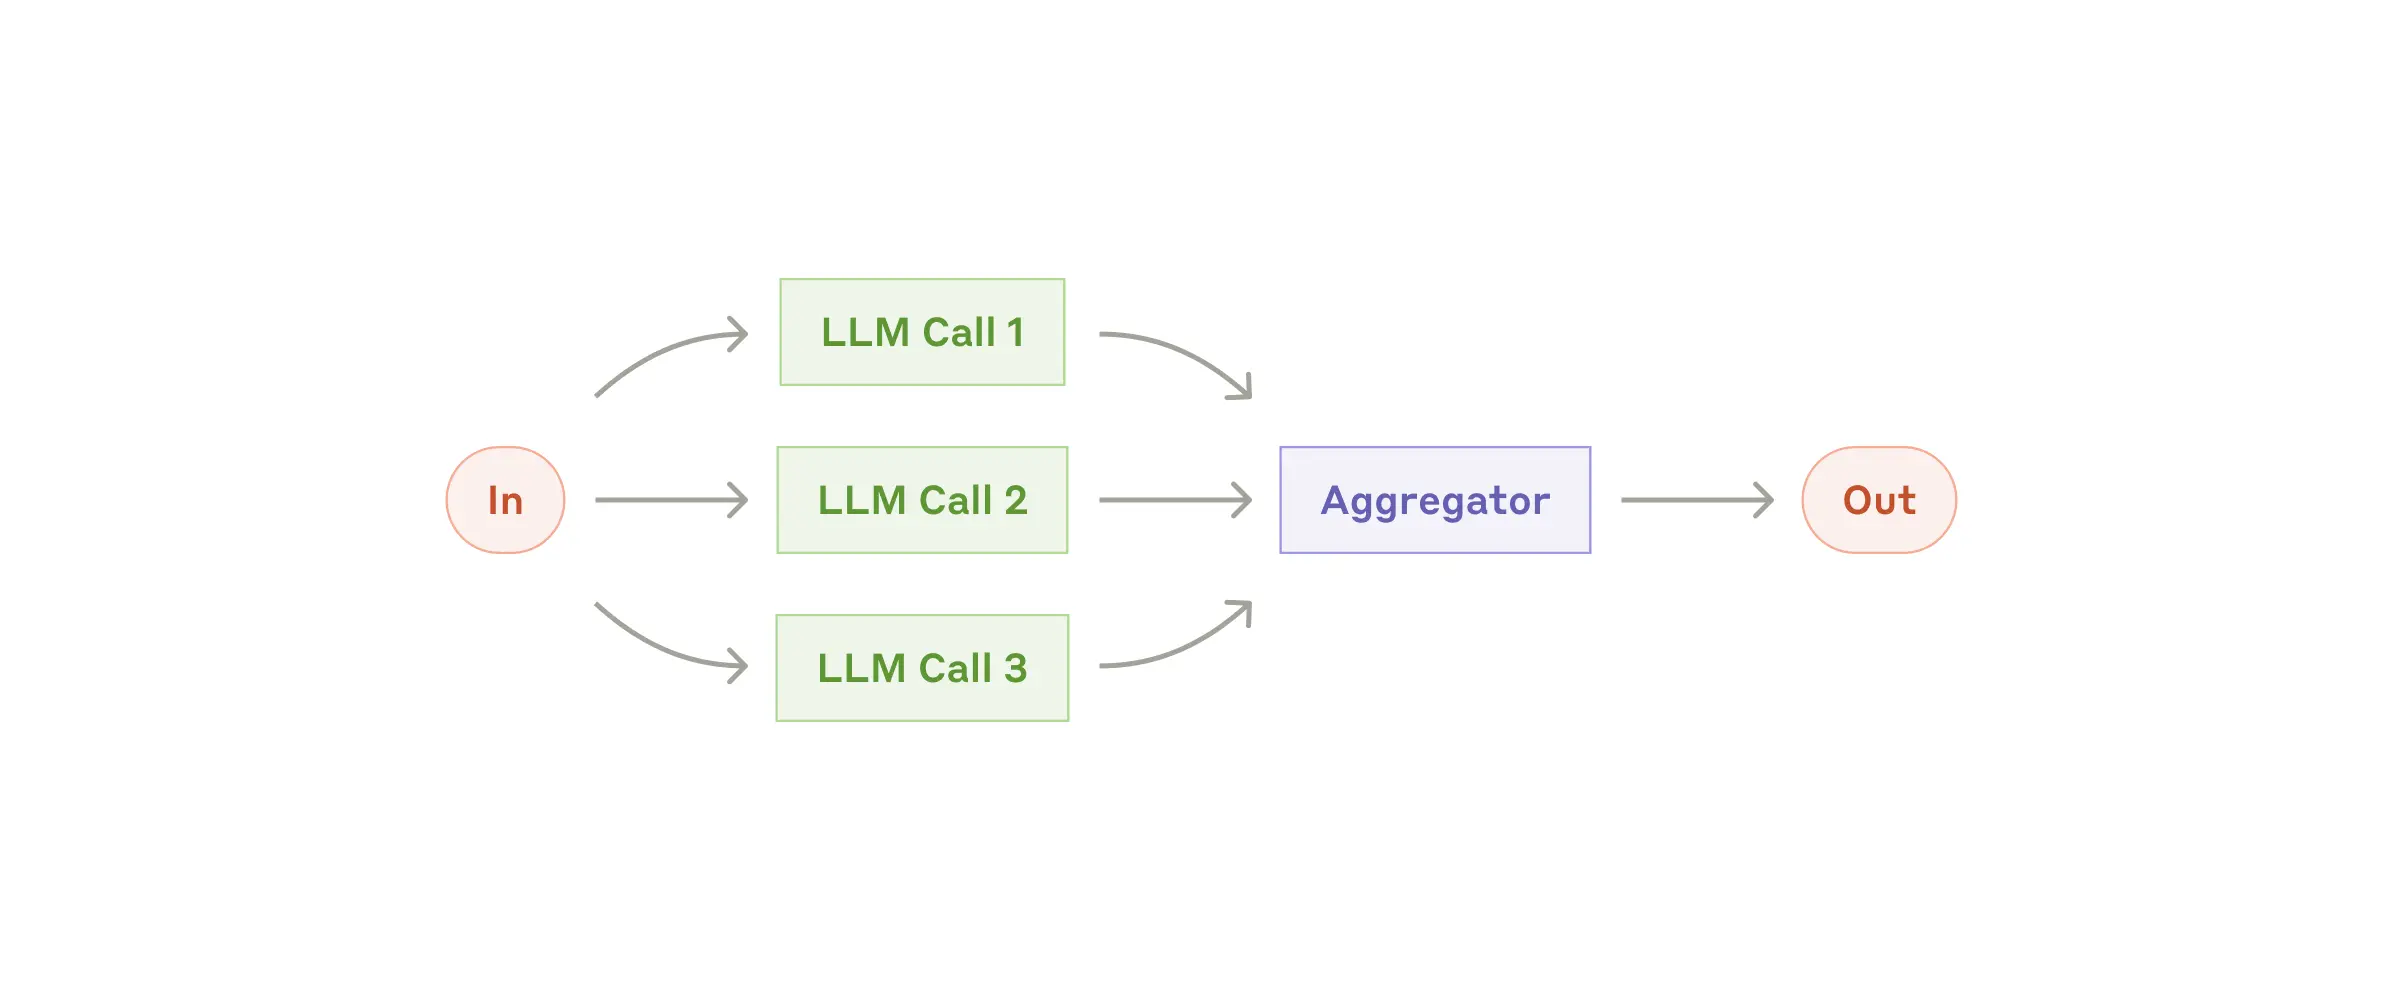

#### Resources

**Documentation**

See our documentation on parallelization here:

https://langchain-ai.github.io/langgraph/how-tos/branching/

**LangChain Academy**
 
See our lesson on parallelization here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb

#### Example Implementation

In [10]:
from concurrent.futures import Future

In [11]:
@task
def call_llm_1(topic: str):
    """ First LLM call to generate initial joke """
    msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content

@task
def call_llm_2(topic: str):
    """ Second LLM call to generate story """
    msg = llm.invoke(f"Write a story about {topic}")
    return msg.content

@task
def call_llm_3(topic):
    """ Third LLM call to generate poem """
    msg = llm.invoke(f"Write a poem about {topic}")
    return msg.content

@task
def aggregator(topic, joke, story, poem):
    """ Combine the joke and story into a single output """

    combined = f"Here's a story, joke, and poem about {topic}!\n\n"
    combined += f"STORY:\n{story}\n\n"
    combined += f"JOKE:\n{joke}\n\n"
    combined += f"POEM:\n{poem}"
    return combined


# Build workflow 
@entrypoint()
def parallel_workflow(topic: str):
    joke_fut = call_llm_1(topic)
    story_fut = call_llm_2(topic)
    poem_fut = call_llm_3(topic)
    return aggregator(topic, joke_fut.result(), story_fut.result(), poem_fut.result()).result()

In [12]:
for step in parallel_workflow.stream("cats", stream_mode="updates"):
    print(step)
    print("\n")

{'call_llm_1': 'Why did the cat sit on the computer?  \n\nBecause it wanted to keep an eye on the mouse!'}


{'call_llm_3': "In the hush of twilight's gentle sway,  \nWhiskered shadows come out to play.  \nGraceful dancers on silent feet,  \nMasters of the night, discreet.  \n\nEmerald eyes, like lanterns bright,  \nPierce the velvet cloak of night.  \nSoft as whispers, their fur aglow,  \nA silken touch, a quiet show.  \n\nThey prowl the garden, kings and queens,  \nIn a realm of moonlit dreams.  \nWith tails aloft, they weave a tale,  \nOf daring quests and moonbeam trails.  \n\nA purr, a nuzzle, a tender paw,  \nA creature both of myth and lore.  \nFrom ancient temples to cozy hearths,  \nThey've claimed our hearts in endless paths.  \n\nCompanions through the ebb of time,  \nIn their mystique, we find our rhyme.  \nFor in the gaze of a knowing cat,  \nLies a universe, infinite and vast.  \n\nSo let us cherish their gentle grace,  \nThese enigmatic souls we embrace.  \nFor in the wo

## Routing 

Routing classifies an input and directs it to a specialized followup task. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

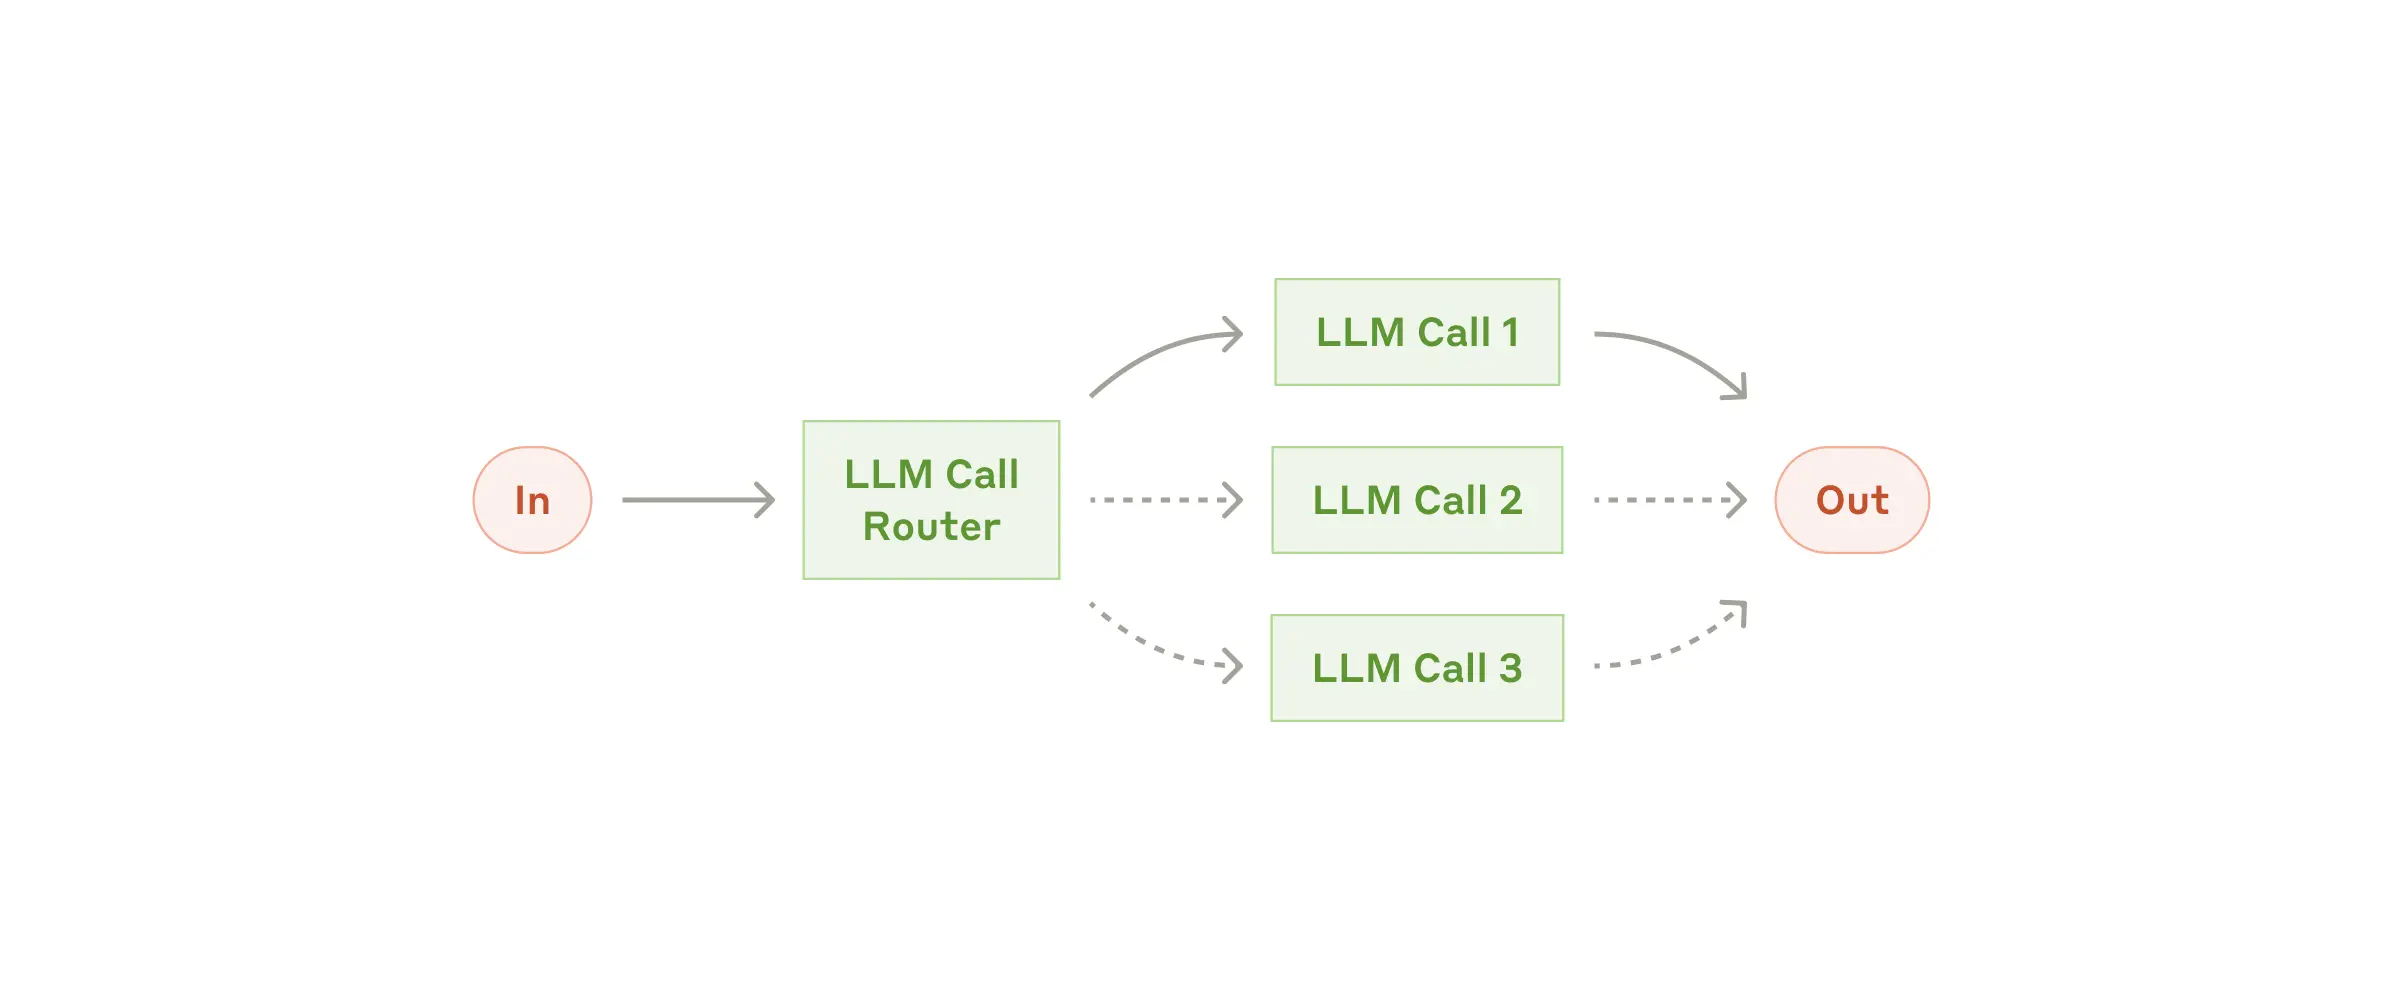

#### Resources

**LangChain Academy**

See our lesson on routing here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb

**Examples**

Here is a project on RAG that utilizes routing to route questions to a vectorstore or web search: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

In [13]:
from typing_extensions import Literal
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

@task
def llm_call_1(input_: str):
    """Write a story """
    result = llm.invoke(input_)
    return result.content

@task
def llm_call_2(input_: str):
    """Write a joke """
    result = llm.invoke(input_)
    return result.content

@task
def llm_call_3(input_: str):
    """Write a poem """
    result = llm.invoke(state['input'])
    return result.content

def llm_call_router(input_: str):
    """ Route the input to the appropriate node """
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke([SystemMessage(content="Route the input to story, joke, or poem based on the user's request."), 
                              HumanMessage(content=input_)])
    return decision.step    



# Compile workflow
@entrypoint()
def router_workflow(input_: str):
    next_step = llm_call_router(input_)
    if next_step == "story":
        llm_call = llm_call_1
    elif next_step == "joke":
        llm_call = llm_call_2
    elif next_step == "poem":
        llm_call = llm_call_3

    return llm_call(input_).result()

In [14]:
for step in router_workflow.stream("Write me a joke about cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_2': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'router_workflow': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}




## Orchestrator-Worker 

A central LLM dynamically breaks down task, delegates them to worker LLMs, and synthesizes their results. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

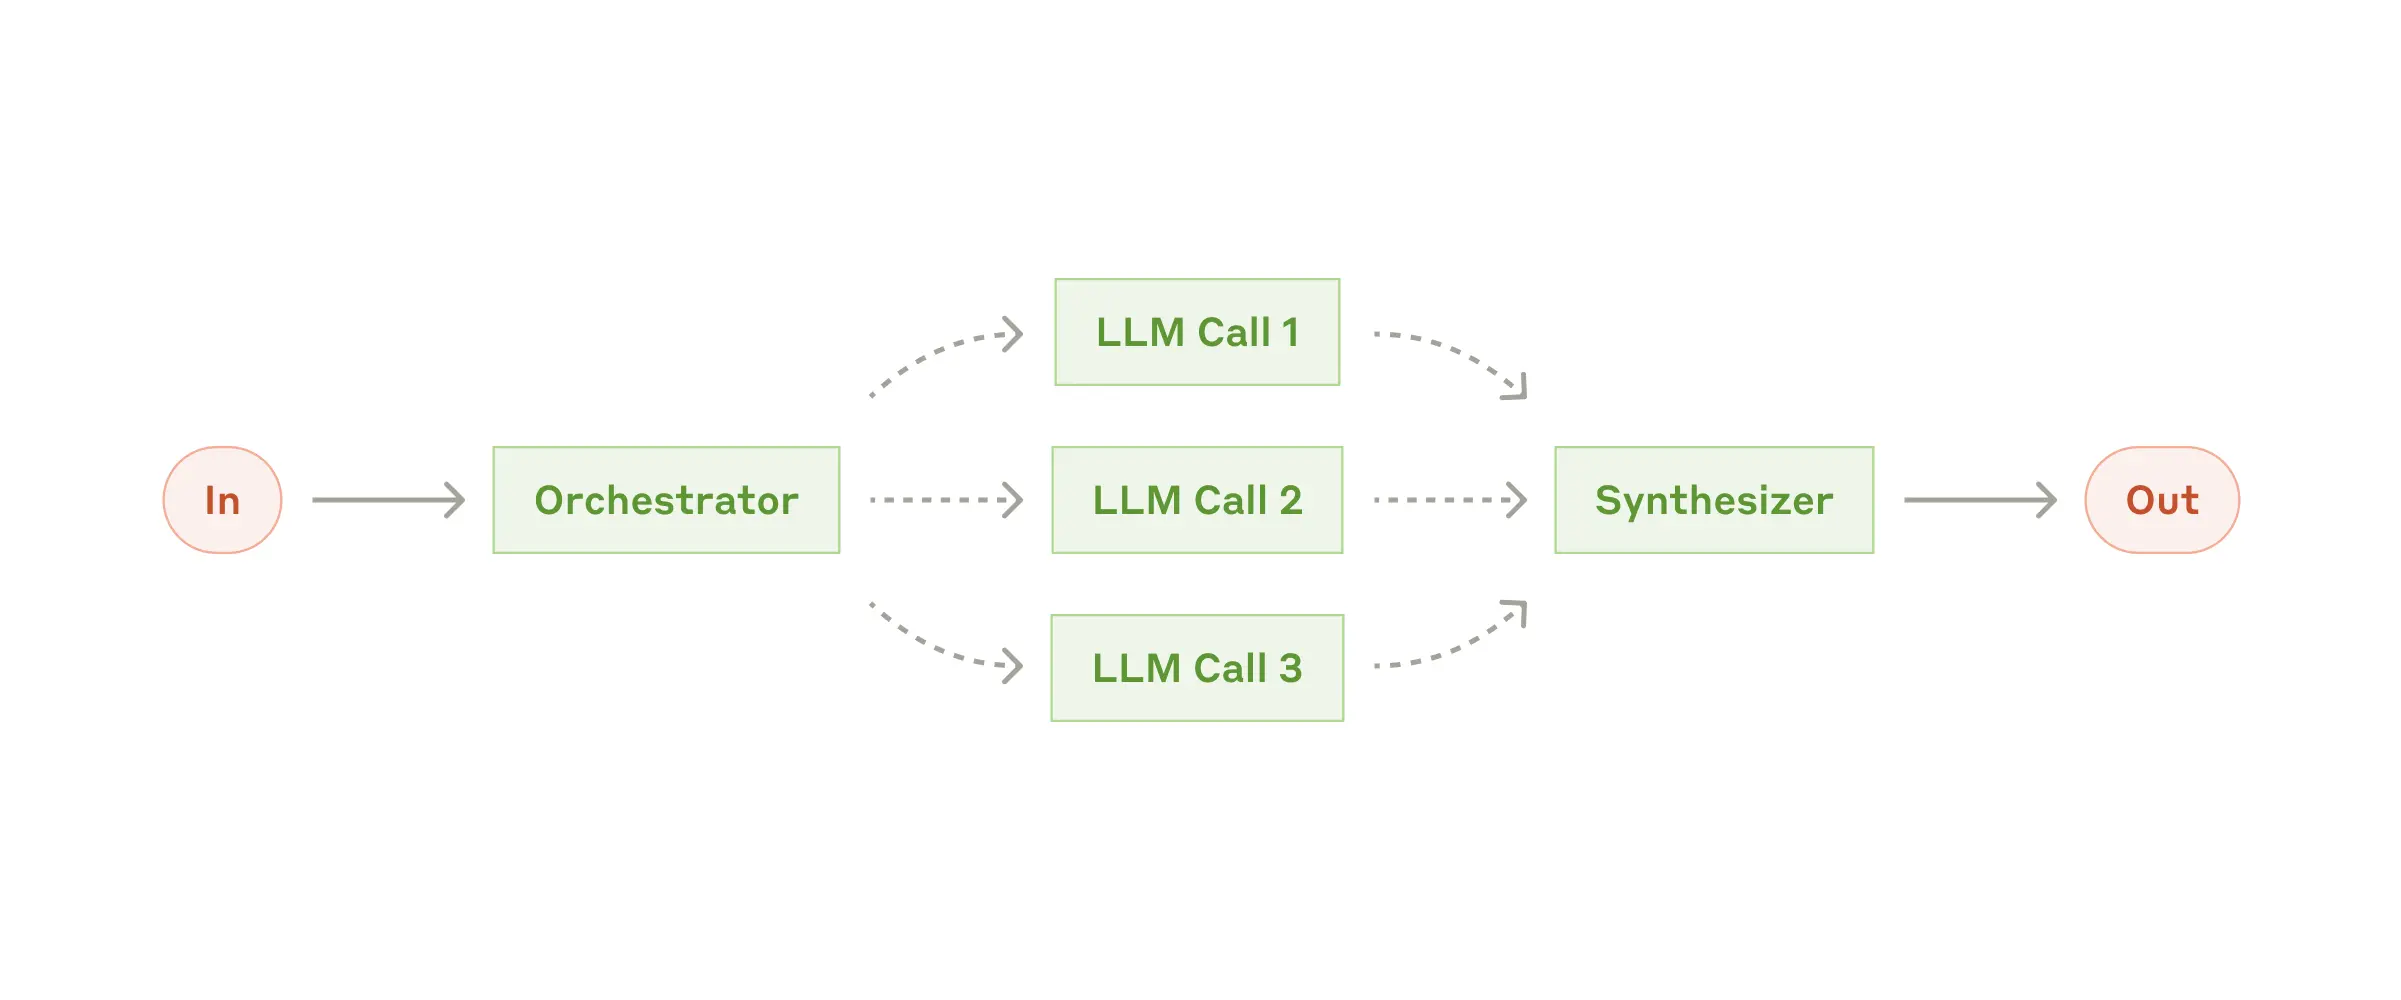

#### Resources

**LangChain Academy**

See our lesson on orchestrator-worker here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb

--- 

**Examples**

Here is a project that uses orchestrator-worker for report planning and writing:

https://github.com/langchain-ai/report-mAIstro

See our video here:

https://www.youtube.com/watch?v=wSxZ7yFbbas
    
#### Example Implementation


In [15]:
from typing import Annotated,List
import operator

# Schema for structured output to use in planning 
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

#### Creating Workers in LangGraph

Because orchestrator-worker workflows are so common, LangGraph **has a specific `Send` API to support this**.

It lets you dynamically create worker nodes and send each one a specific input.

Each worker has its own state, and all worker outputs are written to a *shared state key* that is accessible to the orchestrator graph.

This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.

As you can see below, we iterate over a list of sections and `Send` each to a worker node.

See further documentation here:

https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

https://langchain-ai.github.io/langgraph/concepts/low_level/#send

In [16]:
@task
def orchestrator(topic: str):
    """ Orchestrator that generates a plan for the report """
    # Generate queries  
    report_sections = planner.invoke([SystemMessage(content="Generate a plan for the report."),
                                      HumanMessage(content=f"Here is the report topic: {topic}")])

    return report_sections.sections

@task
def llm_call(section: Section):
    """ Worker writes a section of the report """

    # Generate section  
    result = llm.invoke([SystemMessage(content="Write a report section."),
                         HumanMessage(content=f"Here is the section name: {section.name} and description: {section.description}")])

    # Write the updated section to completed sections
    return result.content

@task
def synthesizer(completed_sections: list[str]):
    """ Synthesize full report from sections """    
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


@entrypoint()
def orchestrator_worker(topic: str):
    sections = orchestrator(topic).result()
    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer([section_fut.result() for section_fut in section_futures]).result()
    return final_report

In [17]:
for step in orchestrator_worker.stream("Create a report on LLM scaling laws", stream_mode="updates"):
    print(step)
    print("\n")

{'orchestrator': [Section(name='Introduction to LLM Scaling Laws', description='An overview of what LLM (Large Language Model) scaling laws are, including their significance and impact on AI development. This section will set the stage by introducing key concepts and terminology.'), Section(name='History and Evolution of LLM Scaling Laws', description='A historical perspective on how LLM scaling laws have developed over time, highlighting major milestones and key research studies that have contributed to our current understanding.'), Section(name='Mathematical Foundations of Scaling Laws', description='A deep dive into the mathematical principles and theories that underpin LLM scaling laws, including discussions on model size, data requirements, and computational limits.'), Section(name='Empirical Evidence and Case Studies', description='Presentation of empirical studies and real-world case studies that illustrate the application and validation of LLM scaling laws in various AI models.

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

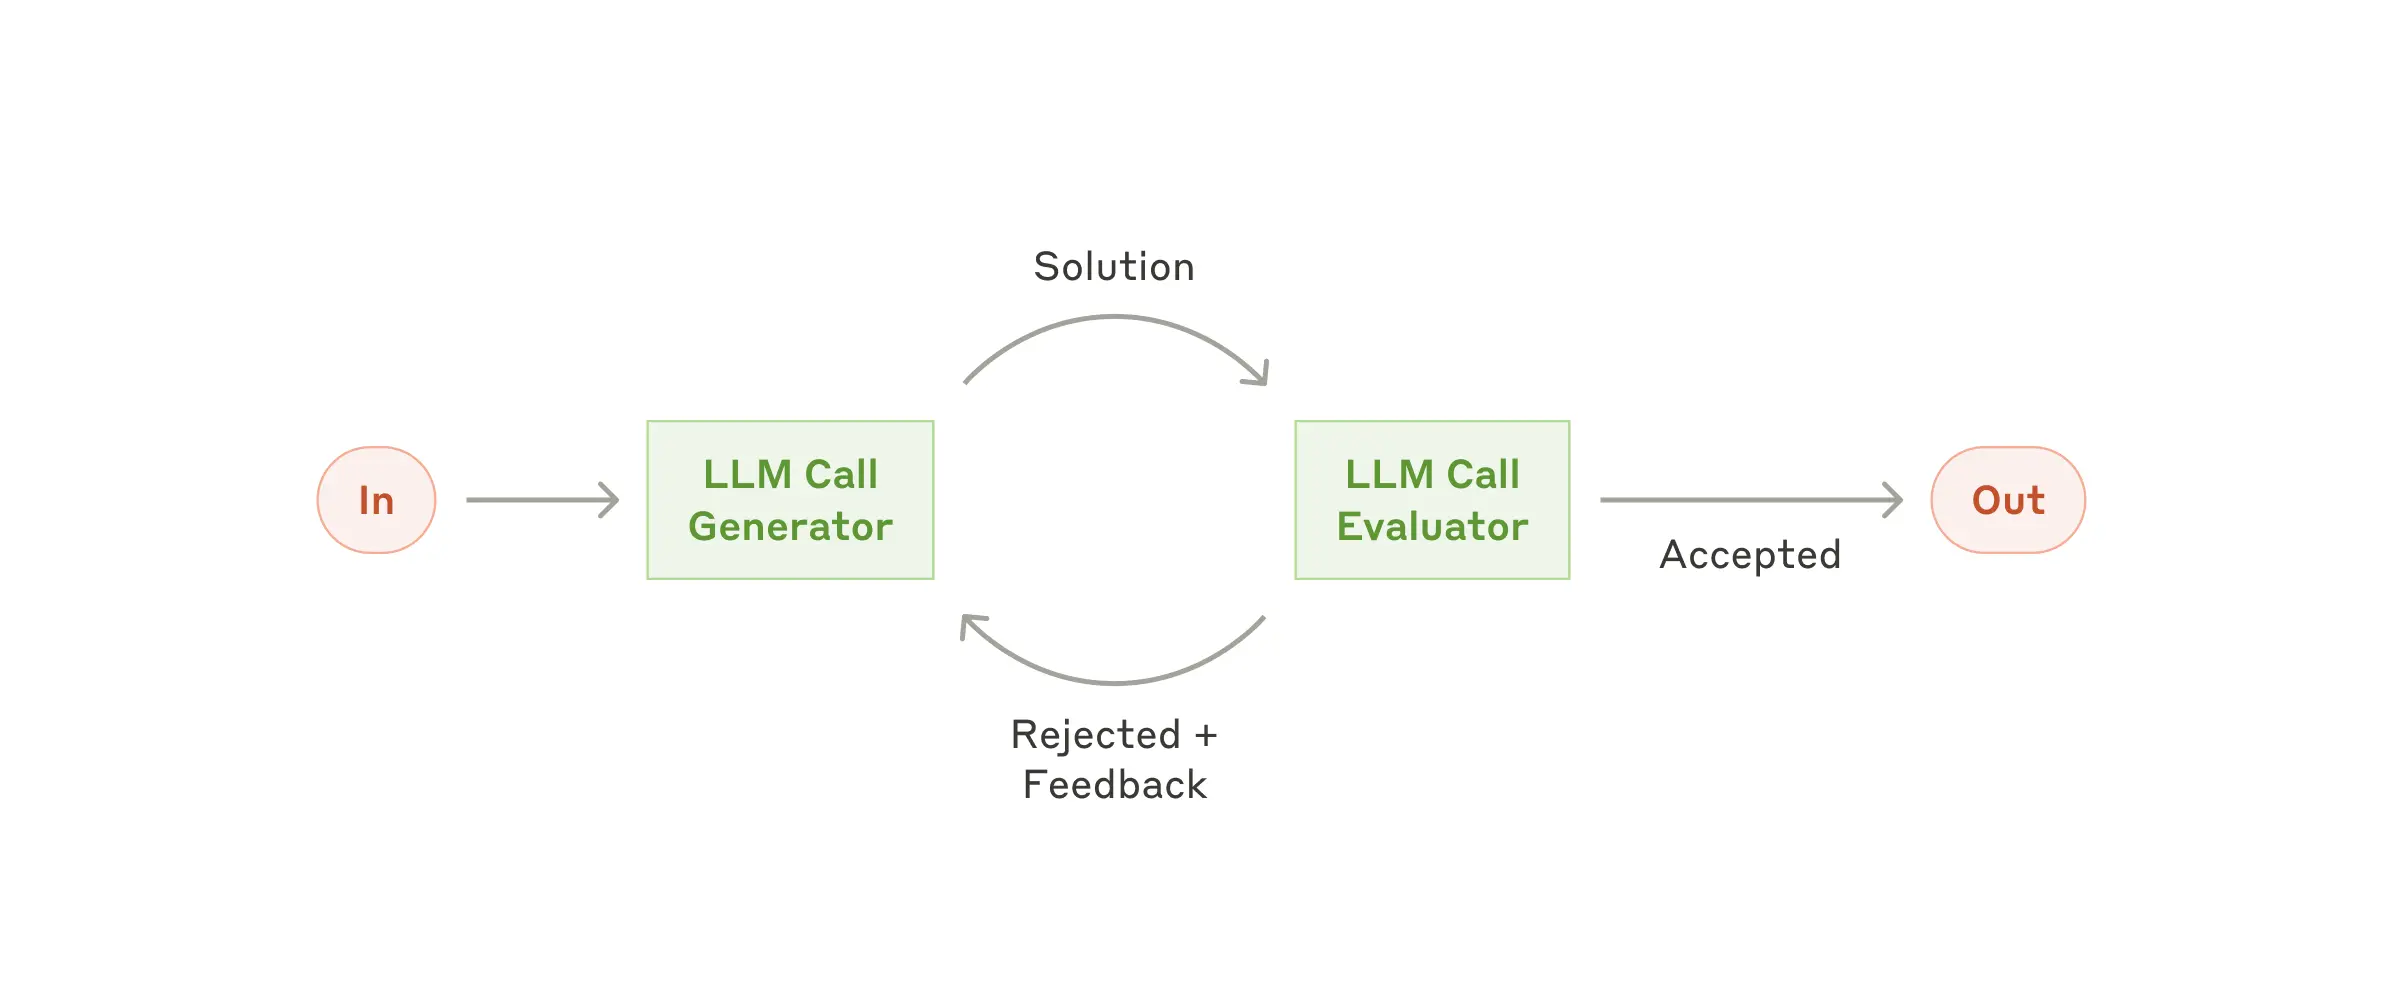

#### Resources

**Examples**

Here is a project that uses evaluator-optimizer to iteratively improve a report:

https://github.com/langchain-ai/research-rabbit

See our video on here:

https://www.youtube.com/watch?v=XGuTzHoqlj8

--- 

Here is a project on RAG that utilizes grading to check answers for hallucinations or factual errors: 

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/ 

See our video on here:

https://www.youtube.com/watch?v=bq1Plo2RhYI

#### Example Implementation

In [18]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

# Nodes 
@task
def llm_call_generator(topic: str, feedback: Feedback):
    """ LLM generates a joke """
    if feedback:
        msg = llm.invoke(f"Write a joke about {topic} but take into account the feedback: {feedback}")
    else:
        msg = llm.invoke(f"Write a joke about {topic}")
    return msg.content

@task
def llm_call_evaluator(joke: str):
    """ LLM evaluates the joke """
    feedback = evaluator.invoke(f"Grade the joke {joke}")
    return feedback


@entrypoint()
def optimizer_workflow(topic: str):
    feedback = None
    while True:
        joke = llm_call_generator(topic, feedback).result()
        feedback = llm_call_evaluator(joke).result()
        if feedback.grade == "funny":
            break

    return joke

In [19]:
for step in optimizer_workflow.stream("Cats", stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call_generator': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}


{'llm_call_evaluator': Feedback(grade='funny', feedback='The joke is clever and uses a play on words, connecting the computer mouse with a real mouse that a cat might be interested in. It has a good punchline that follows the setup well.')}


{'optimizer_workflow': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}




## Agent 

Agents are typically just LLMs using tools based on environmental feedback in a loop. As noted in the [blog post](https://www.anthropic.com/research/building-effective-agents): 

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

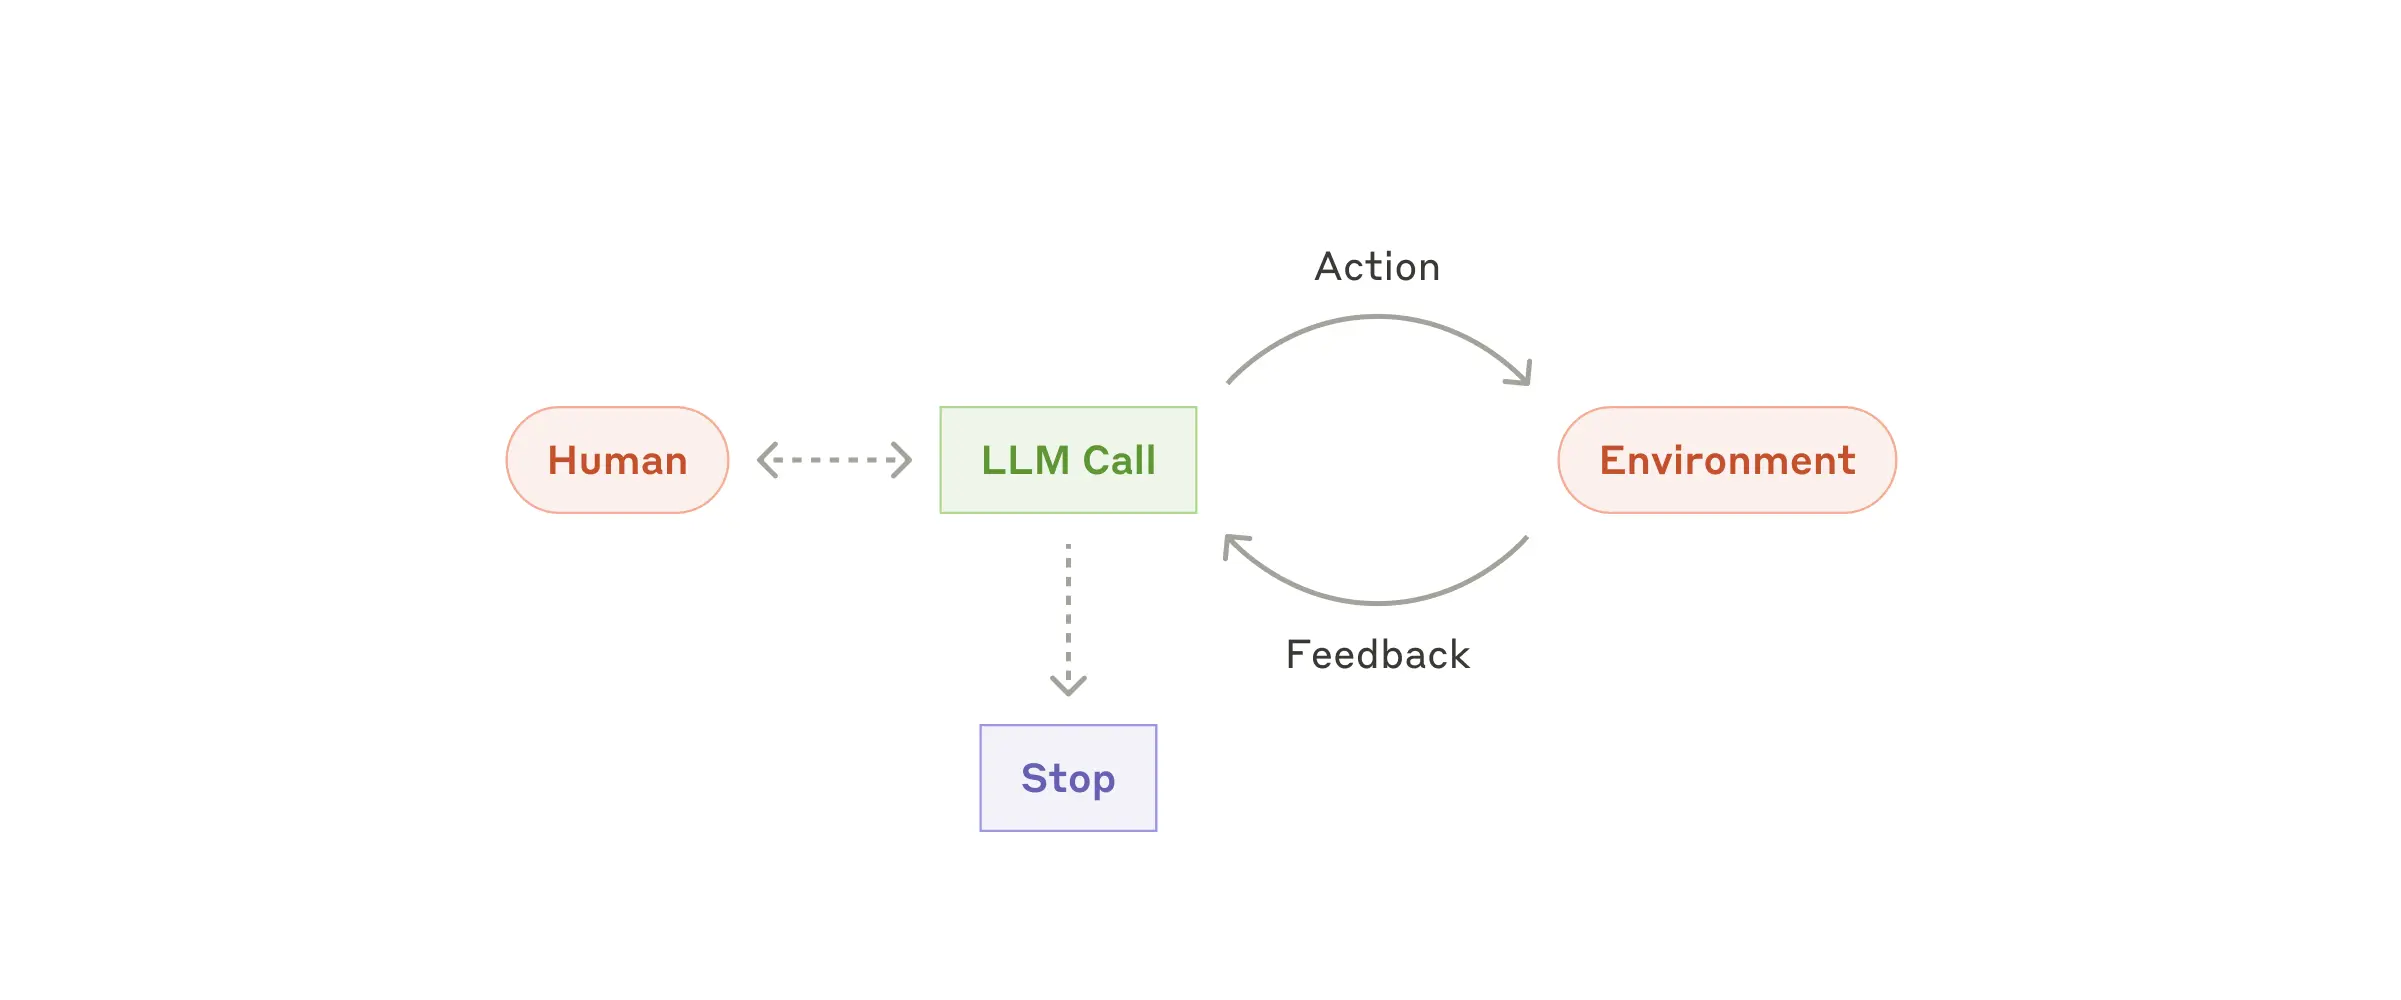

#### Resources

**LangChain Academy**

See our lesson on agents here: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb

--- 

**Examples**

Here is a project that uses a tool calling agent to create / store long-term memories:

https://github.com/langchain-ai/memory-agent

#### Example Implementation


In [20]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [21]:
from langgraph.graph import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage, BaseMessage


@task
def call_llm(messages: list[BaseMessage]):
    """ LLM decides whether to call a tool or not """
    return llm_with_tools.invoke([SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")] + messages)


@task
def call_tools(last_message: AIMessage):
    """ Performs the tool call"""
    results = []
    for tool_call in last_message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        results.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return results


# Compile the agent
@entrypoint()
def agent(messages: list[BaseMessage]):    
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        tool_response = call_tools(llm_response).result()
        messages = add_messages(messages, [llm_response, *tool_response])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

In [22]:
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mWtvRfxIxUwtoNILTirvIETY', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-985966a9-7165-4abf-93fc-cd41533a98ab-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_mWtvRfxIxUwtoNILTirvIETY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 18, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'c

#### Pre-built 

We also have a **pre-built method** for creating an agent as defined above (using the `create_react_agent` method):

https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

In [24]:
from langgraph.prebuilt import create_react_agent

# Pass in: 
# (1) the augmented LLM with tools 
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm_with_tools, tools=tools)

In [25]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_e0Av4db03OnTQHEUVTunH4L7)
 Call ID: call_e0Av4db03OnTQHEUVTunH4L7
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


## Human-in-the-loop examples

### Orchestrator-Worker

You might want to review the plan generated by the orchestrator and provide feedback. To do so you can utilize [`interrupt()`](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt) API. Notice that we now need to provide a `checkpointer` to persist the results of the task executions.

In [26]:
from typing import Optional
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command


@task
def orchestrator(topic: str, feedback: Optional[str]):
    """ Orchestrator that generates a plan for the report """
    # Generate queries  
    
    if feedback:
        system_prompt = f"Generate a plan for the report, but take into account the feedback: {feedback}."
    else:
        system_prompt = "Generate a plan for the report."

    report_sections = planner.invoke([SystemMessage(content=system_prompt),
                                      HumanMessage(content=f"Here is the report topic: {topic}")])
    return report_sections.sections


@task
def llm_call(section: Section):
    """ Worker writes a section of the report """

    # Generate section  
    result = llm.invoke([SystemMessage(content="Write a report section."),
                         HumanMessage(content=f"Here is the section name: {section.name} and description: {section.description}")])

    # Write the updated section to completed sections
    return result.content


@task
def synthesizer(completed_sections: list[str]):
    """ Synthesize full report from sections """    
    final_report = "\n\n---\n\n".join(completed_sections)
    return final_report


checkpointer = MemorySaver()
@entrypoint(checkpointer=checkpointer)
def orchestrator_worker(topic: str):
    sections = orchestrator(topic, None).result()

    while True:
        # interrupt to collect feedback
        user_feedback = interrupt("Please provide feedback for the orchestrator's plan:")
        if user_feedback["action"] == "rewrite":
            feedback = f"\n- Previously generated sections: {sections}.\n- User feedback: {user_feedback['feedback']}"
            sections = orchestrator(topic, feedback).result()
        else:
            break

    section_futures = [llm_call(section) for section in sections]
    final_report = synthesizer([section_fut.result() for section_fut in section_futures]).result()
    return final_report

In [27]:
config = {"configurable": {"thread_id": "1"}}

In [28]:
for step in orchestrator_worker.stream("Create a report on LLM scaling laws", config, stream_mode="updates"):
    print(step)
    print("\n")

{'orchestrator': [Section(name='Introduction to LLM Scaling Laws', description='This section will provide an overview of what LLM Scaling Laws are, including their significance in the field of artificial intelligence and machine learning. It will introduce the basic principles and objectives of studying scaling laws in language models.'), Section(name='Historical Development and Key Milestones', description='This section will cover the historical development of scaling laws in language models, highlighting key milestones and breakthroughs in the field. It will discuss how the understanding of scaling laws has evolved over time.'), Section(name='Theoretical Foundations of Scaling Laws', description='This section will delve into the theoretical underpinnings of scaling laws, explaining how they are formulated and validated. It will cover the mathematical models and assumptions that form the basis of scaling laws in language models.'), Section(name='Empirical Studies and Experiments', des

In [29]:
for step in orchestrator_worker.stream(Command(resume={"action": "rewrite", "feedback": "Limit to maximum of 5 sections, including intro and conclusion"}), config, stream_mode="updates"):
    print(step)
    print("\n")

{'orchestrator': [Section(name='Introduction to LLM Scaling Laws', description='This section will provide a concise overview of LLM Scaling Laws, highlighting their importance and foundational concepts in AI and machine learning.'), Section(name='Historical Development and Key Milestones', description='This section will cover the historical development of scaling laws in language models, highlighting key milestones and breakthroughs in the field. It will discuss how the understanding of scaling laws has evolved over time.'), Section(name='Theoretical Foundations and Empirical Studies', description='This section will combine the theoretical underpinnings of scaling laws with a summary of major empirical studies and experiments. It will explain the formulation, validation, and key findings from these theoretical and empirical perspectives.'), Section(name='Applications, Implications, and Challenges', description='This section will explore the practical applications of scaling laws and th

In [30]:
for step in orchestrator_worker.stream(Command(resume={"action": "approve"}), config, stream_mode="updates"):
    print(step)
    print("\n")

{'llm_call': '## Applications, Implications, and Challenges\n\n### Applications of Scaling Laws\n\nScaling laws in artificial intelligence (AI) refer to empirical relationships that describe how changes in model size, data quantity, and computational resources affect the performance of machine learning models. These laws have profound implications for both AI research and industry practices, offering a roadmap for the development of more capable AI systems.\n\nIn practice, scaling laws have been leveraged to guide the design of state-of-the-art language models, such as GPT-3 and its successors. By understanding how model performance scales with size and data, researchers can make informed decisions about resource allocation, leading to more efficient and effective models. Furthermore, scaling laws have been applied to optimize neural architecture search, streamline hyperparameter tuning, and enhance transfer learning strategies. These applications have contributed to significant advanc

### Agent

Another use case for human-in-the-loop is tool call approval. Let's see how this can be implemented using the [`interrupt()`](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt) API:

In [31]:
from langgraph.graph import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage, BaseMessage


@task
def call_llm(messages: list[BaseMessage]):
    """ LLM decides whether to call a tool or not """
    return llm_with_tools.invoke([SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")] + messages)


@task
def call_tools(last_message: AIMessage):
    """ Performs the tool call"""
    results = []
    for tool_call in last_message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        results.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return results


checkpointer = MemorySaver()
@entrypoint(checkpointer=checkpointer)
def agent(messages: list[BaseMessage]):    
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        tool_call = llm_response.tool_calls[-1]
        # interrupt to collect human review
        human_review = interrupt(
            {
                "question": "Is this correct?",
                # Surface tool calls for review
                "tool_call": tool_call,
            }
        )
        if human_review["action"] == "update":
            llm_response = AIMessage(
                content=llm_response.content,
                tool_calls=[
                    {
                        "id": tool_call["id"],
                        "name": tool_call["name"],
                        # This the update provided by the human
                        "args": human_review["tool_args"],
                    }
                ],
                id=llm_response.id,
            )

        tool_response = call_tools(llm_response).result()
        messages = add_messages(messages, [llm_response, *tool_response])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

In [32]:
config = {"configurable": {"thread_id": "1"}}

In [33]:
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, config, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lYVLsuVHs7kkSuOQf27aAY0H', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ced68154-9e39-467e-9279-0e2e9f0a299c-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_lYVLsuVHs7kkSuOQf27aAY0H', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 18, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'_

In [34]:
for chunk in agent.stream(Command(resume={"action": "update", "tool_args": {"a": 3.0, "b": 4}}), config, stream_mode="updates"):
# for chunk in agent.stream(Command(resume={"action": "approve"}), config, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_tools': [ToolMessage(content='7', id='0fa66614-3854-4a7f-99f2-9073c253f1dd', tool_call_id='call_lYVLsuVHs7kkSuOQf27aAY0H')]}


{'call_llm': AIMessage(content='The sum of 3 and 4 is 7.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 177, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-6a63fa3b-77e0-4ad8-b544-43fe07a7049a-0', usage_metadata={'input_tokens': 177, 'output_tokens': 14, 'total_tokens': 191, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'agent': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='6a80802

---

## What LangGraph provides

By constructing each of the above in LangGraph, we get a few things that are important for building effective agents and workflows.

### Streaming 

LangGraph provides several ways to stream state of the agent or workflow. 

See Module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb

### Human-in-the-Loop

LangGraph persistence layer supports interruption and approval of the agent's actions (e.g., Human In The Loop). 

See Module 3 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-3

### Memory 

LangGraph persistence layer supports conversational (short-term) memory as well as long-term memory. 

See Modules 2 and 5 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-2

https://github.com/langchain-ai/langchain-academy/tree/main/module-5

### Deployment and Observability

LangGraph provides an easy on-ramp for deployment, observability, and evaluation. 

See module 6 of LangChain Academy: 

https://github.com/langchain-ai/langchain-academy/tree/main/module-6